In [1]:
from adan_pytorch import Adan
from fastai.vision.all import *

import wandb
from fastai.callback.wandb import WandbCallback

# Adan: A new optimizer that looks cool!

Let's take a look at Adam first, the default optimizer from fastai.

In [2]:
path = untar_data(URLs.IMAGENETTE_160)

In [5]:
def get_learner(img_size=128, arch="convnext_tiny", opt_func=Adam):
    dls = ImageDataLoaders.from_folder(path, valid='val', 
        item_tfms=RandomResizedCrop(img_size, min_scale=0.35), batch_tfms=Normalize.from_stats(*imagenet_stats))
    return vision_learner(dls, arch, metrics=accuracy, pretrained=False, opt_func=opt_func).to_fp16()

In [6]:
default_config = SimpleNamespace(lr=1e-3, wd=1e-3, epochs=20, arch="convnext_tiny", img_size=128, opt_func=Adam)

In [8]:
learn = get_learner(default_config.img_size, default_config.arch, partial(SGD, mom=0.9))

SuggestedLRs(valley=0.0004786300996784121)

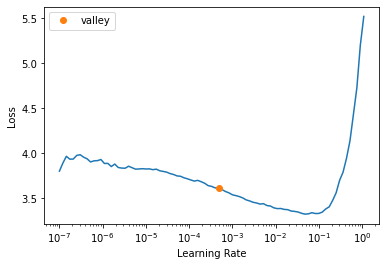

In [9]:
learn.lr_find()

In [21]:
def fit(config, group="Adam"):
    with wandb.init(project="adan_optimizer", group=group, config=config):
        
        learn.fit_one_cycle(config.epochs, config.lr, wd=config.wd, cbs=WandbCallback(log_preds=False))

In [14]:
for _ in range(3):
    fit(default_config)

epoch,train_loss,valid_loss,accuracy,time
0,2.723775,2.012296,0.333758,00:13
1,2.470017,1.919287,0.356178,00:13
2,2.220914,1.832933,0.405605,00:13
3,1.980961,1.720401,0.421401,00:13
4,1.722866,1.565472,0.483822,00:13
5,1.580196,1.418032,0.530701,00:13
6,1.413366,1.360435,0.544968,00:13
7,1.336158,1.538224,0.494013,00:13
8,1.284008,1.178715,0.610701,00:13
9,1.168299,1.282999,0.566879,00:13


accuracy,▁▁▂▃▄▅▅▄▆▅▆▇▇▇██████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,▇▆▆█▅▅▅▅▄▄▄▃▃▃▃▃▃▃▂▂▃▃▃▃▂▂▃▂▃▃▁▂▂▂▂▂▂▁▁▂
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


epoch,train_loss,valid_loss,accuracy,time
0,2.773562,2.033905,0.329427,00:13
1,2.527506,1.926126,0.358981,00:13
2,2.275418,1.845122,0.389045,00:13
3,1.979571,1.820999,0.428790,00:13
4,1.753766,1.524645,0.475414,00:13
5,1.571985,1.471901,0.504204,00:13
6,1.442558,1.368005,0.536306,00:13
7,1.359522,1.489330,0.523057,00:13
8,1.251095,1.195963,0.612739,00:13
9,1.192831,1.114447,0.637452,00:13


accuracy,▁▂▂▃▄▄▅▅▆▇▇▇▇███████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,██▆▇▅▅▅▅▄▄▄▃▃▃▃▄▂▃▃▃▂▂▃▂▂▁▂▃▁▂▁▁▂▁▂▂▂▂▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


epoch,train_loss,valid_loss,accuracy,time
0,2.702499,1.951239,0.338599,00:13
1,2.459817,1.938814,0.366115,00:13
2,2.191274,1.749918,0.393885,00:13
3,1.985592,1.637743,0.443312,00:13
4,1.725449,1.506076,0.509809,00:13
5,1.562118,1.478267,0.503185,00:13
6,1.436052,1.322734,0.565096,00:13
7,1.292638,1.251792,0.592102,00:14
8,1.238197,1.098901,0.642293,00:13
9,1.180166,1.184538,0.613248,00:13


accuracy,▁▂▂▃▄▄▅▆▇▆▇▇▇▇██████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▇█▆▆▆▅▆▄▅▅▅▄▂▂▃▄▄▃▃▃▃▂▂▃▃▂▂▂▂▂▁▂▂▁▂▃▂▂
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


## Adan

In [12]:
adan = partial(OptimWrapper, opt=partial(Adan, betas=(0.02, 0.08, 0.01)))
adan_config = SimpleNamespace(lr=1e-2, wd=2e-2, epochs=20, arch="convnext_tiny", img_size=128, opt_func=adan)

In [15]:
for _ in range(3):
    fit(adan_config, group="Adan")

epoch,train_loss,valid_loss,accuracy,time
0,2.948633,2.320297,0.246369,00:18
1,2.510164,2.258260,0.231847,00:18
2,2.184628,1.975261,0.347261,00:18
3,2.004548,2.120599,0.305223,00:18
4,1.887561,1.806982,0.378599,00:19
5,1.741313,1.662697,0.427516,00:18
6,1.617101,1.696903,0.427006,00:17
7,1.559285,1.492492,0.490701,00:17
8,1.450328,1.444072,0.510318,00:17
9,1.335099,1.446789,0.508280,00:17


accuracy,▁▁▃▂▃▄▄▅▅▅▆▇▇▇██████
betas__2_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
betas__2_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,▇█▇▆▅▆▄▆▄▄▄▄▄▄▃▄▄▃▃▄▃▃▄▂▃▂▂▂▁▂▂▂▂▂▂▂▂▁▂▂


epoch,train_loss,valid_loss,accuracy,time
0,2.870041,2.270078,0.249427,00:17
1,2.575136,2.192493,0.235924,00:17
2,2.221539,2.130176,0.311847,00:17
3,2.012240,2.202504,0.269554,00:17
4,1.866776,1.771510,0.390318,00:17
5,1.721145,1.728336,0.424968,00:17
6,1.635352,1.836481,0.330955,00:17
7,1.483802,1.616787,0.452484,00:18
8,1.363524,1.330179,0.550318,00:17
9,1.284320,1.281345,0.574013,00:17


accuracy,▁▁▂▁▃▄▂▄▅▆▅▆▇▇██████
betas__2_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
betas__2_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,██▇▇▆▆▆▅▅▅▄▄▄▄▃▃▄▂▄▂▃▂▂▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁


epoch,train_loss,valid_loss,accuracy,time
0,2.677541,2.115150,0.314650,00:17
1,2.317958,1.895637,0.384459,00:17
2,2.039999,2.255267,0.277707,00:17
3,1.844754,1.629728,0.469299,00:17
4,1.692849,1.709659,0.433376,00:18
5,1.586840,1.579016,0.482038,00:17
6,1.486158,1.581885,0.453758,00:17
7,1.377867,1.382448,0.545223,00:17
8,1.297308,1.258224,0.587516,00:17
9,1.232613,1.202026,0.594650,00:17


accuracy,▂▃▁▄▃▄▄▅▆▆▆▆▇▇██████
betas__2_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
betas__2_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▂▂▃▄▅▆▇███████▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▆▅▅▅▅▅▄▄▄▃▃▄▃▃▃▄▃▂▂▃▂▂▂▃▃▂▂▂▁▁▂▂▂▁▂▁▁▂▁
